# Dense networks for 3D images
Each object is represented by 3 views (elevation, plan, section) and a texture image. However, not all objects have a texture image. Therefore, __in this notebook__ I will train and evaluate an ensemble of 3 classifiers (fig. 1), one for each 3D-view, using all the data (split in train, validate and test datasets). In the next notebook, I will add a texture classifier and re-train the ensemble using only the objects for which a texture was provided.

<img src="fig/ML_3D_only.png">

_Figure 1: Overview of the classifier ensemble using only 3D views._


## Load feature data

In [1]:
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder

PROD_DIR = 'production' # interim production files

# Reload extracted features from train dataset
with np.load(os.path.join(PROD_DIR, 'features_point_clouds_train.npz'), allow_pickle=True) as data:
    data_dict = dict(data.items())
    metadata_train = data_dict['metadata']
    elevation_features_train = data_dict['elevation_features']
    plan_features_train = data_dict['plan_features']
    section_features_train = data_dict['section_features']

# encode labels as ints
labels_train = LabelEncoder().fit_transform(metadata_train[:, 3]) # 'period' is the 3rd column
    
# Reload extracted features from validate dataset
with np.load(os.path.join(PROD_DIR, 'features_point_clouds_validate.npz'), allow_pickle=True) as data:
    data_dict = dict(data.items())
    metadata_valid = data_dict['metadata']
    elevation_features_valid = data_dict['elevation_features']
    plan_features_valid = data_dict['plan_features']
    section_features_valid = data_dict['section_features']

# encode labels as ints
labels_valid = LabelEncoder().fit_transform(metadata_valid[:, 3]) # 'period' is the 3rd column

# Reload extracted features from test dataset
with np.load(os.path.join(PROD_DIR, 'features_point_clouds_test.npz'), allow_pickle=True) as data:
    data_dict = dict(data.items())
    metadata_test = data_dict['metadata']
    elevation_features_test = data_dict['elevation_features']
    plan_features_test = data_dict['plan_features']
    section_features_test = data_dict['section_features']

# encode labels as ints
labels_test = LabelEncoder().fit_transform(metadata_test[:, 3]) # 'period' is the 3rd column


## Baseline

In [2]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(elevation_features_train, labels_train)
baseline_score = dummy.score(elevation_features_valid, labels_valid)
print('The accuracy of the most frequent baseline is {:.2f}.'.format(baseline_score))

The accuracy of the most frequent baseline is 0.34.


## Define dense networks

For each of the 3D-views, I implemented a dense network with multiple layers:

* The input data for the network are 2048 high-level features extracted from each of the 3d-views in the previous notebook.
* The data is not linearly separable (notebook 3), therfore this network needs a hidden layer. Chosing the number of nodes in the hidden layer is a problem for which [some heristics](http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html) exist, but no definitive answer. 
* I added a dropout layer with a dropout rate of 0.5, to prevent overfitting.
* The images are in 6 classes ('Bronze Age', 'Iron Age', etc.), therefore the network requires 6 outputs.

I chose to implement the network using Keras.

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import activations
from tensorflow.keras import initializers

def define_network(outputs, hidden_nodes, rate):
    """
    Defines a multi-layer dense network with a hidden and a dropout layer.
    @param out_nodes: int, number of outputs
    @param hidden_nodes: int, number of nodes in the hidden layer
    @param rate: float, rate of the dropout layer
    """
    network = Sequential()
    # hidden layer
    network.add(
        Dense(
            hidden_nodes, 
            activation='relu', 
            kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)
        )
    )
    # dropout layer
    network.add(
        keras.layers.Dropout(rate, seed=0)
    )
    # output layer
    network.add(
        Dense(
            outputs, # number of image classes
            activation='softmax', # 'softmax' since output layer for classification network
            kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0)
        )
    )
    return network

### Grid search
The networks for each 3D-view are trained independently from each other. I used grid search to tune the number of nodes in the hidden layer (between 8 and 128) and the dropout rate (between 0.4 and 0.7) of each network.

In [4]:
import pandas as pd
from sklearn.model_selection import ParameterGrid

# create a grid of tunable parameters
# the same grid is used for all networks
grid = ParameterGrid({
    'nw__num_nodes': [2**i for i in range(3, 12)], # between 8 and 2048
    'nw__dropout_rate': [0.5] #  actually, the dropout rate doesn't change the result in this case
})

# callback for early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

def fit_network(num_nodes, dropout_rate, X_train, y_train, X_valid, y_valid):
    """
    Fit a network as defined in define_network().
    @param best_num_nodes int, number of nodes in the hidden layer
    @params X_train, y_train, X_valid, y_valid numpy ndarrays
    @return fitted tensorflow network ('Sequential' object), tensorflow fit history ('History' object)
    """
    # define and compile the model with best number of nodes and rate
    outputs = 6
    network = define_network(outputs, num_nodes, dropout_rate) 
    network.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc']) # using defaults
    # fit network on training set, compute accuracy on validation set (from notebook 3)
    history = network.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_valid, y_valid), # do not use split, feed validation data directly
        batch_size=256, # using a batch size larger than the default
        epochs=1000, # combine many epochs with early stopping
        callbacks=[early_stopping],
        shuffle=True,
        verbose=0
    )
    return network, history

def optimize_params(X_train, y_train, X_valid, y_valid):
    """
    Optimize the number of nodes in the hidden layer and the dropout rate of the network defined in define_network().
    @params X_train, y_train, X_valid, y_valid numpy ndarrays
    @return best_num_nodes int, best_rate float, accuracy Pandas DataFrame
    """
    test_scores = []
    for params_dict in grid:
        # keras API is not compatible with ParameterGrid, so read grid parameters by hand
        network, history = fit_network(
            params_dict['nw__num_nodes'], 
            params_dict['nw__dropout_rate'], 
            X_train, y_train, X_valid, y_valid)
        params_dict['accuracy'] = history.history['val_acc'][-1] # the validation accuracy of the model, last epoch
        test_scores.append(params_dict)

    accuracy_df = pd.DataFrame(test_scores)
    accuracy_df.sort_values(by='accuracy', ascending=False, inplace=True)
    best_num_nodes = accuracy_df.loc[accuracy_df['accuracy'].idxmax(), 'nw__num_nodes']
    best_rate = accuracy_df.loc[accuracy_df['accuracy'].idxmax(), 'nw__dropout_rate']
    return best_num_nodes, best_rate, accuracy_df

#### Optimizing number of nodes in hidden layer for elevation view

In [5]:
best_num_nodes_elevation, best_rate_elevation, elevation_accuracy = optimize_params(elevation_features_train, labels_train, elevation_features_valid, labels_valid)
print(elevation_accuracy.head(10), '\n')
print('Best parameters for elevation view, nodes in hidden layer {}, dropout rate {}\n'.format(best_num_nodes_elevation, best_rate_elevation))

   accuracy  nw__dropout_rate  nw__num_nodes
8  0.708333               0.5           2048
5  0.697917               0.5            256
7  0.697917               0.5           1024
6  0.687500               0.5            512
3  0.682292               0.5             64
1  0.677083               0.5             16
2  0.677083               0.5             32
4  0.677083               0.5            128
0  0.666667               0.5              8 

Best parameters for elevation view, nodes in hidden layer 2048, dropout rate 0.5



#### Optimizing number of nodes in hidden layer for plan view

In [6]:
best_num_nodes_plan, best_rate_plan, plan_accuracy = optimize_params(plan_features_train, labels_train, plan_features_valid, labels_valid)
print(plan_accuracy.head(10), '\n')
print('Best parameters for plan view, nodes in hidden layer {}, dropout rate {}\n'.format(best_num_nodes_plan, best_rate_plan))

   accuracy  nw__dropout_rate  nw__num_nodes
3  0.692708               0.5             64
2  0.677083               0.5             32
5  0.677083               0.5            256
8  0.671875               0.5           2048
1  0.666667               0.5             16
7  0.666667               0.5           1024
0  0.661458               0.5              8
4  0.656250               0.5            128
6  0.656250               0.5            512 

Best parameters for plan view, nodes in hidden layer 64, dropout rate 0.5



#### Optimizing number of nodes in hidden layer for section view

In [7]:
best_num_nodes_section, best_rate_section, section_accuracy = optimize_params(section_features_train, labels_train, section_features_valid, labels_valid)
print(section_accuracy.head(10), '\n')
print('Best parameters for section view, nodes in hidden layer {}, dropout rate {}\n'.format(best_num_nodes_section, best_rate_section))

   accuracy  nw__dropout_rate  nw__num_nodes
8  0.723958               0.5           2048
7  0.713542               0.5           1024
5  0.708333               0.5            256
0  0.703125               0.5              8
1  0.697917               0.5             16
6  0.687500               0.5            512
2  0.682292               0.5             32
3  0.682292               0.5             64
4  0.682292               0.5            128 

Best parameters for section view, nodes in hidden layer 2048, dropout rate 0.5



### Define and fit each network
For each 3D-view, define a network with the optimal number of nodes in the hidden layer as determined in the previous step, fit the network.

In [8]:
# define and fit a network for each 3D-view
elevation_network, elevation_history = fit_network(best_num_nodes_elevation, best_rate_elevation, elevation_features_train, labels_train, elevation_features_valid, labels_valid)
plan_network, plan_history = fit_network(best_num_nodes_plan, best_rate_plan, plan_features_train, labels_train, plan_features_valid, labels_valid)
section_network, section_history = fit_network(best_num_nodes_section, best_rate_section, section_features_train, labels_train, section_features_valid, labels_valid)

### Plot the networks' accuracy
Plot the accuracy of each network separately.

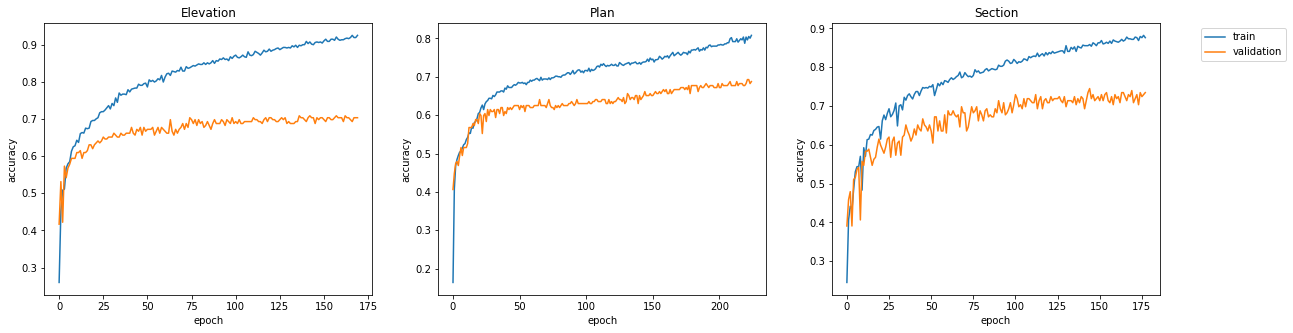

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy(ax, history, title):
    ax.plot(history.history['acc'], label='train')
    ax.plot(history.history['val_acc'], label='validation')
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.set_title(title)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plot_accuracy(ax[0], elevation_history, 'Elevation')
plot_accuracy(ax[1], plan_history, 'Plan')
plot_accuracy(ax[2], section_history, 'Section')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.show();

### Accuracy on the test set for each network

In [10]:
elevation_score = elevation_network.evaluate(elevation_features_test, labels_test, verbose=0)[1]
print('The accuracy for the network trained on the elevation views on the test set is {:.2f}'.format(elevation_score))
plan_score = plan_network.evaluate(plan_features_test, labels_test, verbose=0)[1]
print('The accuracy for the network trained on the plan views on the test set is {:.2f}'.format(plan_score))
section_score = section_network.evaluate(section_features_test, labels_test, verbose=0)[1]
print('The accuracy for the network trained on the section views on the test set is {:.2f}'.format(section_score))

The accuracy for the network trained on the elevation views on the test set is 0.82
The accuracy for the network trained on the plan views on the test set is 0.71
The accuracy for the network trained on the section views on the test set is 0.75


Save the fitted networks for later use

In [11]:
elevation_network.save_weights('production/elevation_network.ckpt')
plan_network.save_weights('production/plan_network.ckpt')
section_network.save_weights('production/section_network.ckpt')



Consider using a TensorFlow optimizer from `tf.train`.

Consider using a TensorFlow optimizer from `tf.train`.

Consider using a TensorFlow optimizer from `tf.train`.


In [3]:
elevation_network = define_network(best_elevation)
elevation_network.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc'])
elevation_network.load_weights('production/elevation_network.ckpt')
elevation_network.evaluate(elevation_features_test, labels_test, verbose=0)[1]

NameError: name 'best_elevation' is not defined

## Combine results
The results of the individual classifiers have to be combined into one final result for the ensemble.

## Compare the accuracies

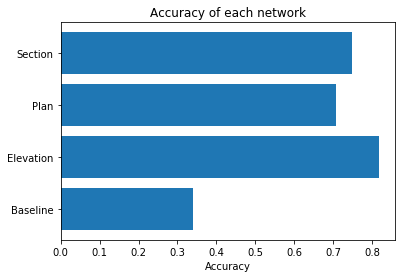

In [12]:
plt.barh(['Baseline', 'Elevation', 'Plan', 'Section'], width=[baseline_score, elevation_score, plan_score, section_score])
plt.xlabel('Accuracy')
plt.ylabel('')
plt.title('Accuracy of each network')
plt.show();

# Test

In [16]:
def fit_network(best_num_nodes, X_train, y_train, X_valid, y_valid):
    """
    Fit a network as defined in define_network().
    @param best_num_nodes int, number of nodes in the hidden layer
    @params X_train, y_train, X_valid, y_valid numpy ndarrays
    @return fitted tensorflow network ('Sequential' object), tensorflow fit history ('History' object)
    """
    # define and compile the model with best number of nodes
    network = define_network(best_num_nodes) 
    network.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc']) # using defaults
    # fit
    history = network.fit(
        x=X_train,
        y=y_train,
        validation_data=(X_valid, y_valid), # do not use split, feed validation data directly
        batch_size=128, # using a batch size larger than the default
        epochs=200, # combine many epochs with early stopping
        callbacks=[early_stopping],
        shuffle=True,
        verbose=0
    )
    return network, history


test_network, test_history = fit_network(1022, elevation_features_train, labels_train, elevation_features_valid, labels_valid)
test_network.evaluate(elevation_features_test, labels_test, verbose=0)[1]

0.8080808083818416